<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; ">Freight value prediction</h1>
</div>


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 1 -Nettoyage des données</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Import des librairies</h3>
</div>

In [3]:
import pandas as pd
import numpy as np
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from scipy.stats import spearmanr, ttest_1samp, ttest_ind, shapiro, f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import Ridge
from scipy.stats import chi2_contingency

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Récuperation des fichiers </h3>
</div>

In [61]:
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
geolocations = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
name_translations = pd.read_csv("product_category_name_translation.csv")

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.3 - Merge des données  </h3>
</div>

In [5]:
# Merge de tout les tableaux en un grand tableau à 40 colonnes 
data = customers.merge(orders, on = 'customer_id')\
                .merge(items, on = 'order_id')\
                .merge(payments, on = 'order_id')\
                .merge(reviews, on = 'order_id')\
                .merge(products, on = 'product_id')\
                .merge(name_translations, on = 'product_category_name')\
                .merge(sellers, on = 'seller_id')
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,ce2172509c4149d65212484eb761bc37,c5da6424f1f5decedef8672a1a0103e1,88350,brusque,SC,edcf1e1eeb52381be9388c90152be52d,delivered,2018-08-21 11:29:05,2018-08-21 11:50:47,2018-08-21 15:37:00,...,1002.0,3.0,1900.0,19.0,16.0,16.0,arts_and_craftmanship,95910,lajeado,RS
115605,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP,2ef4a11b6e24fdfbb43b92cb5f95edff,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,...,660.0,3.0,500.0,16.0,6.0,16.0,arts_and_craftmanship,17201,jau,SP
115606,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP,2ef4a11b6e24fdfbb43b92cb5f95edff,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,...,942.0,5.0,500.0,21.0,7.0,14.0,arts_and_craftmanship,17201,jau,SP
115607,ab0cf72dfe0538a63a57d6905ccb7b57,8c3c961a52bb5a0ffbce1d4e6d25cd67,35930,joao monlevade,MG,2c12150c742ae2fa48bc703964c16c5f,delivered,2018-07-28 17:55:27,2018-07-29 18:30:31,2018-07-30 14:54:00,...,923.0,5.0,1000.0,25.0,25.0,25.0,arts_and_craftmanship,17201,jau,SP


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.4 - Rassemblement des données utiles </h3>
</div>

On récupère les données importantes pour une commande et les positionnent dans un dataframe

In [6]:
df_order = data[['order_id','order_purchase_timestamp','order_item_id','product_id','price','freight_value','customer_unique_id']]
df_order.head()

,order_id,order_purchase_timestamp,order_item_id,product_id,price,freight_value,customer_unique_id
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,861eff4711a542e4b93843c6dd7febb0
1,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,9eae34bbd3a474ec5d07949ca7de67c0
2,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,9eae34bbd3a474ec5d07949ca7de67c0
3,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,15.62,3c799d181c34d51f6d44bbbc563024db
4,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,1,a9516a079e37a9c9c36b9b78b10169e8,106.99,30.59,23397e992b09769faf5e66f9e171a241


In [7]:
df_customer = data[['customer_id','customer_unique_id','customer_zip_code_prefix','customer_city','customer_state']]
df_customer

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ
...,...,...,...,...,...
115604,ce2172509c4149d65212484eb761bc37,c5da6424f1f5decedef8672a1a0103e1,88350,brusque,SC
115605,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP
115606,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP
115607,ab0cf72dfe0538a63a57d6905ccb7b57,8c3c961a52bb5a0ffbce1d4e6d25cd67,35930,joao monlevade,MG


On enlèves les lignes ayant des valeurs nulles dans notre dataframe

In [8]:
data.dropna(axis = 0, inplace = True)

On réalise la même chose sur le dataset des géolocalisations pour obtenir des zip code uniques 

In [9]:
geolocations.dropna(inplace=True)
geolocations.drop_duplicates(subset="geolocation_zip_code_prefix",inplace=True)
geolocations.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP


Cela nous permet donc de merge nos dataframe geolocalisation et df_customer pour ainsi obtenir la position du client 

In [10]:
df_customer = df_customer.merge(geolocations, left_on="customer_zip_code_prefix", 
                                right_on="geolocation_zip_code_prefix", how="left")

In [11]:
df_customer = df_customer[["customer_id","customer_unique_id","customer_zip_code_prefix","customer_city"
                           ,"customer_state","geolocation_lat","geolocation_lng"]]
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,-2.442747,-54.728950
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,-2.442747,-54.728950
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,-29.856534,-51.268958
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,-22.627556,-43.159942


On récupère des positions uniques pour chaque client 

In [12]:
cust_locs = df_customer[[
    'customer_unique_id',
    'geolocation_lat',
    'geolocation_lng'
]].groupby('customer_unique_id').mean().reset_index()
cust_locs.head(5)

,customer_unique_id,geolocation_lat,geolocation_lng
0,0000366f3b9a7992bf8c76cfdf3221e2,-23.335331,-46.828647
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-23.567395,-46.792957
2,0000f46a3911fa3c0805444483337064,-27.543787,-48.625680
3,0000f6ccb0745a6a4b88665a16c9f078,-1.311011,-48.482884
4,0004aac84e0df4da2b147fca70cf8255,-23.504368,-47.466156


On merge les dataframes order et client pour ainsi avoir la commande 

In [13]:
order_customer_loc = pd.merge(
    left= df_order,
    right= cust_locs,
    on= 'customer_unique_id',
    how= 'left'
).rename(columns= {'geolocation_lat':'cust_lat', 'geolocation_lng':'cust_lng'})[[
    'order_id',
    'customer_unique_id',
    'cust_lat',
    'cust_lng'
]]
order_customer_loc.head()

,order_id,customer_unique_id,cust_lat,cust_lng
0,00e7ee1b050b8499577073aeb2a297a1,861eff4711a542e4b93843c6dd7febb0,-20.509897,-47.397866
1,c1d2b34febe9cd269e378117d6681172,9eae34bbd3a474ec5d07949ca7de67c0,-2.442747,-54.728950
2,c1d2b34febe9cd269e378117d6681172,9eae34bbd3a474ec5d07949ca7de67c0,-2.442747,-54.728950
3,b1a5d5365d330d10485e0203d54ab9e8,3c799d181c34d51f6d44bbbc563024db,-29.856534,-51.268958
4,2e604b3614664aa66867856dba7e61b7,23397e992b09769faf5e66f9e171a241,-22.627556,-43.159942


In [14]:
df_order_items = data[["order_id","order_item_id","product_id","seller_id"
                       ,"shipping_limit_date","price","freight_value"]]
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
44,64a9f2b487f66506d463ca18152280e8,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-03-09 09:47:40,116.99,18.53
45,54d6f9d8f56229d3da815add65ec2408,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-05 11:15:35,116.99,57.08
46,54d6f9d8f56229d3da815add65ec2408,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-05 11:15:35,116.99,57.08
57,626434e11c37535d5f24e9d844249b55,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-19 02:15:14,116.99,57.08
58,626434e11c37535d5f24e9d844249b55,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-19 02:15:14,116.99,57.08


On repète maintenant les premières étapes mais cette fois ci pour les vendeurs 

In [15]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [16]:
df_seller = sellers.merge(geolocations, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
df_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,13844.0,-22.382941,-46.946641,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,20031.0,-22.910641,-43.176510,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,4195.0,-23.657250,-46.610759,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,12914.0,-22.971648,-46.533618,bragança paulista,SP


In [17]:
df_seller.rename(columns={"geolocation_lat" : "seller_lat", "geolocation_lng" : "seller_lng"},inplace=True)
df_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,seller_lat,seller_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,13844.0,-22.382941,-46.946641,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,20031.0,-22.910641,-43.176510,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,4195.0,-23.657250,-46.610759,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,12914.0,-22.971648,-46.533618,bragança paulista,SP


In [18]:
sell_loc = df_seller[[
    'seller_id',
    'seller_lat',
    'seller_lng'
]].groupby('seller_id').mean().reset_index()
sell_loc.head()

,seller_id,seller_lat,seller_lng
0,0015a82c2db000af6aaaf3ae2ecb0532,-23.644439,-46.539885
1,001cca7ae9ae17fb1caed9dfb1094831,-20.297537,-40.400869
2,001e6ad469a905060d959994f1b41e4f,-22.874040,-43.033089
3,002100f778ceb8431b7a1020ff7ab48f,-20.506794,-47.407738
4,003554e2dce176b5555353e4f3555ac8,-16.648412,-49.311191


In [19]:
sell_order_loc = pd.merge(
    left= df_order_items,
    right= sell_loc,
    on= 'seller_id',
    how= 'left'
)[[
    'order_id',
    'product_id',
    'seller_id',
    'freight_value',
    'seller_lat',
    'seller_lng',
    'price'
]]
sell_order_loc.head()

,order_id,product_id,seller_id,freight_value,seller_lat,seller_lng,price
0,64a9f2b487f66506d463ca18152280e8,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,18.53,-23.482623,-46.37449,116.99
1,54d6f9d8f56229d3da815add65ec2408,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
2,54d6f9d8f56229d3da815add65ec2408,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
3,626434e11c37535d5f24e9d844249b55,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
4,626434e11c37535d5f24e9d844249b55,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99


On rassemble toutes les données 

In [20]:
order_cust_sel_loc = pd.merge(
    left= order_customer_loc,
    right= sell_order_loc,
    on= 'order_id',
    how= 'inner'
).drop_duplicates()
order_cust_sel_loc.head()

,order_id,customer_unique_id,cust_lat,cust_lng,product_id,seller_id,freight_value,seller_lat,seller_lng,price
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,-23.613644,-46.600791,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,18.53,-23.482623,-46.37449,116.99
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,-22.765556,-41.899277,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
5,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,-19.923879,-40.861983,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
14,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,-22.927115,-43.173630,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,36.28,-23.482623,-46.37449,149.98
18,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,-23.742926,-46.710060,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,26.10,-23.482623,-46.37449,159.98


In [21]:
df_product = products[['product_id','product_category_name','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]
df_product.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


On forme une dataframe final pour les analyses predictives en ajoutant les colonnes les plus importantes comme les dimensions , les coordonnées et le poids 

In [22]:
df = pd.merge(
    left= order_cust_sel_loc,
    right= df_product,
    on= 'product_id',
    how= 'left'
)[[
    'order_id',
    'customer_unique_id',
    'product_id',
    'seller_id',
    'cust_lat',
    'cust_lng',
    'seller_lat',
    'seller_lng',
    'product_category_name',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'price',
    'freight_value'
]]
df.head()


,order_id,customer_unique_id,product_id,seller_id,cust_lat,cust_lng,seller_lat,seller_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-23.613644,-46.600791,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,18.53
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-22.765556,-41.899277,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08
2,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-19.923879,-40.861983,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08
3,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,-22.927115,-43.173630,-23.482623,-46.37449,moveis_escritorio,8267.0,52.0,52.0,17.0,149.98,36.28
4,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,-23.742926,-46.710060,-23.482623,-46.37449,moveis_escritorio,12160.0,56.0,51.0,28.0,159.98,26.10


On calcule la distance entre les clients et les vendeurs 

In [23]:
def calc_dist(cust,sel):
    return distance.geodesic(cust,sel).km

df.dropna(subset= [
    'cust_lat',
    'cust_lng',
    'seller_lat',
    'seller_lng'
], inplace= True)

df['distance'] = df[[
    'cust_lat',
    'cust_lng',
    'seller_lat',
    'seller_lng'
]].apply(lambda row: calc_dist((row.cust_lat,row.cust_lng),(row.seller_lat,row.seller_lng)), axis=1)

df.head()

,order_id,customer_unique_id,product_id,seller_id,cust_lat,cust_lng,seller_lat,seller_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value,distance
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-23.613644,-46.600791,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,18.53,27.284813
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-22.765556,-41.899277,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,465.195316
2,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-19.923879,-40.861983,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,693.146796
3,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,-22.927115,-43.173630,-23.482623,-46.37449,moveis_escritorio,8267.0,52.0,52.0,17.0,149.98,36.28,333.379916
4,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,-23.742926,-46.710060,-23.482623,-46.37449,moveis_escritorio,12160.0,56.0,51.0,28.0,159.98,26.10,44.765253


On ajoute le volume pour transformer nos 3 colonnes en une seule 

In [24]:
df['volume_cm3'] = df.product_height_cm * df.product_length_cm * df.product_width_cm
df.head()

,order_id,customer_unique_id,product_id,seller_id,cust_lat,cust_lng,seller_lat,seller_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value,distance,volume_cm3
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-23.613644,-46.600791,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,18.53,27.284813,107136.0
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-22.765556,-41.899277,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,465.195316,107136.0
2,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-19.923879,-40.861983,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,693.146796,107136.0
3,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,-22.927115,-43.173630,-23.482623,-46.37449,moveis_escritorio,8267.0,52.0,52.0,17.0,149.98,36.28,333.379916,45968.0
4,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,-23.742926,-46.710060,-23.482623,-46.37449,moveis_escritorio,12160.0,56.0,51.0,28.0,159.98,26.10,44.765253,79968.0


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 2 - Analyse features importantes </h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Visualisation de la distribution </h3>
</div>

Pour l'analyse les feature choisis sont le poids , la longueur , la hauteur , la largeur , la distance , le volume et le prix qui seront ainsi comparées au frais de port (label)

In [25]:
@interact
def plot_hist(
    column= ['product_weight_g', 'product_length_cm',
            'product_height_cm','product_width_cm',
            'distance','volume_cm3', 'freight_value', 'price']
):
    plt.figure(figsize= (12,8))
    sns.distplot(df[column], kde= True)
    plt.title('Histogram of {}'.format(column), fontdict= {'size':15})

interactive(children=(Dropdown(description='column', options=('product_weight_g', 'product_length_cm', 'produc…

Nous pouvons remarquer que toutes les courbes sont positives 

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Visualisation de la corrélation </h3>
</div>

In [26]:
df.corr(method='pearson')

,cust_lat,cust_lng,seller_lat,seller_lng,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value,distance,volume_cm3
cust_lat,1.000000,0.468820,0.111440,0.126505,-0.007423,-0.021350,-0.009783,-0.023737,0.074868,0.290943,0.709164,-0.010312
cust_lng,0.468820,1.000000,0.083224,0.116526,-0.012163,-0.028457,-0.031598,-0.009930,0.025203,0.097969,0.272506,-0.023658
seller_lat,0.111440,0.083224,1.000000,0.458301,-0.037405,-0.034075,-0.043177,-0.032371,0.025092,0.059733,0.209117,-0.042128
seller_lng,0.126505,0.116526,0.458301,1.000000,-0.014561,-0.068933,-0.012538,-0.069101,0.063353,-0.001439,0.029256,-0.036282
product_weight_g,-0.007423,-0.012163,-0.037405,-0.014561,1.000000,0.543568,0.596332,0.530708,0.341085,0.596988,-0.020160,0.831334
product_length_cm,-0.021350,-0.028457,-0.034075,-0.068933,0.543568,1.000000,0.245531,0.605952,0.188714,0.384606,-0.013579,0.608757
product_height_cm,-0.009783,-0.031598,-0.043177,-0.012538,0.596332,0.245531,1.000000,0.291337,0.214936,0.371523,-0.007481,0.711797
product_width_cm,-0.023737,-0.009930,-0.032371,-0.069101,0.530708,0.605952,0.291337,1.000000,0.176199,0.357811,-0.028299,0.646891
price,0.074868,0.025203,0.025092,0.063353,0.341085,0.188714,0.214936,0.176199,1.000000,0.419524,0.093544,0.321669
freight_value,0.290943,0.097969,0.059733,-0.001439,0.596988,0.384606,0.371523,0.357811,0.419524,1.000000,0.408608,0.582752


<AxesSubplot:>

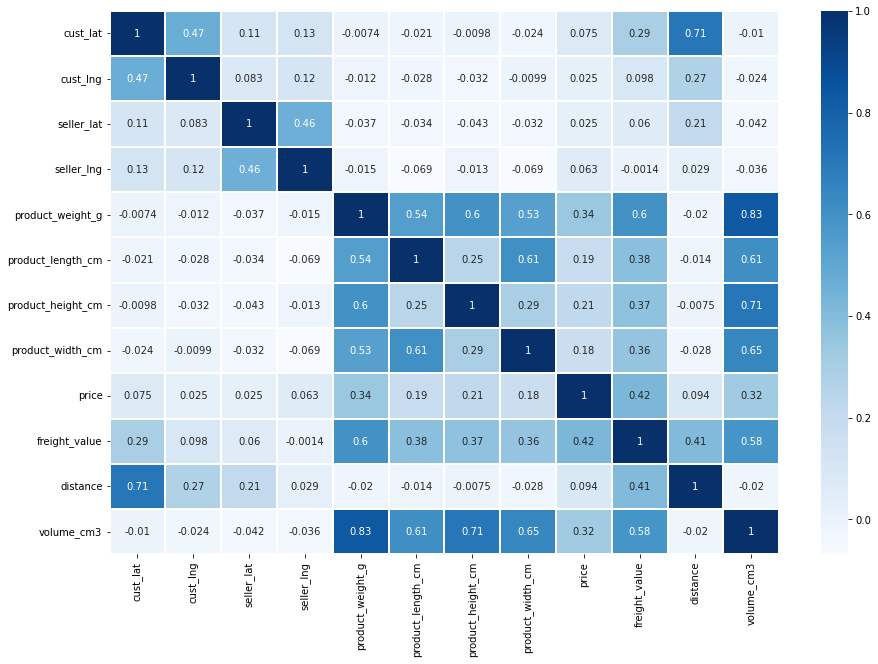

In [27]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, cmap="Blues", annot=True, linewidths=.1)

Observations :

- les dimemsions du produit ont une corrélation positive entre 0.3 et 0.4
- la distance et la feature ayant une corrélation similaire que les dimensions à 0.41
- le poids et le volume sont les features ayant les corrélations les plus élevées à 0.6


on standardize les valeurs des colonnes et on utilise le pca pour obtenir la meilleur visualisation de nos données 

In [68]:
cols = [
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'distance',
    'volume_cm3',
    'price',
    'cust_lat',
    'cust_lng',
    'seller_lat',
    'seller_lng'
]

scaler = StandardScaler()
scaled = scaler.fit_transform(df[cols])

pca = PCA(n_components= 1)
reduced = pca.fit_transform(scaled)
pca_df = pd.DataFrame(reduced, columns= ['component_1'])
pca_df.head()

,component_1
0,5.354999
1,5.308271
2,5.284207
3,2.987810
4,4.785661


<Figure size 864x576 with 0 Axes>

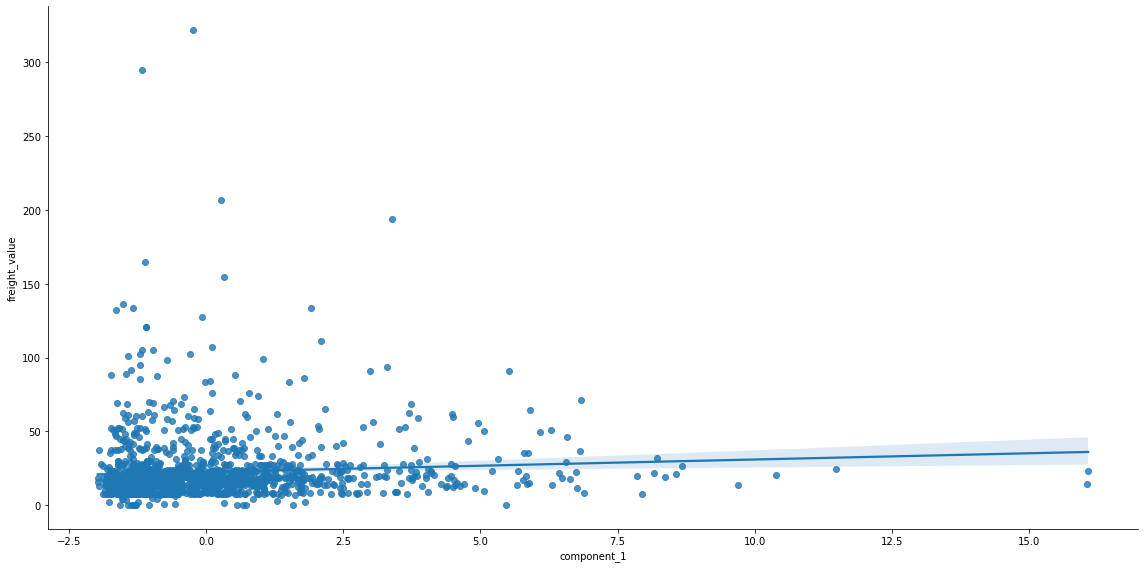

In [69]:
# plot pca with standardized values and freight value 
tmp = pd.concat([pca_df,df.freight_value], axis=1)

plt.figure(figsize= (12,8))
sns.lmplot(
    data=tmp.sample(frac=0.15, random_state= 5),
    x= 'component_1',
    y= 'freight_value',
    legend= True,
    height= 8,
    aspect= 2
)

In [30]:
# plot pca with each features and the freight value
@interact
def plot_lm(
    column= ['product_weight_g', 'product_length_cm',
            'product_height_cm','product_width_cm',
            'distance','volume_cm3', 'cust_lat','cust_lng',
            'seller_lat','seller_lng','price']
):
    sns.lmplot(data= df, x= column, y= 'freight_value', aspect= 2, height= 8)
    plt.title('Linear model plot of {}'.format(column), fontdict= {'size':15})

interactive(children=(Dropdown(description='column', options=('product_weight_g', 'product_length_cm', 'produc…

In [31]:
scaled = pd.DataFrame(scaled, columns = cols)
scaled

,product_weight_g,product_length_cm,product_height_cm,product_width_cm,distance,volume_cm3,price,cust_lat,cust_lng,seller_lat,seller_lng
0,1.780783,1.649460,3.731995,0.784289,-0.933863,4.166190,-0.085789,-0.483691,-0.156184,-0.260637,0.302276
1,1.780783,1.649460,3.731995,0.784289,-0.241913,4.166190,-0.085789,-0.337384,0.980703,-0.260637,0.302276
2,1.780783,1.649460,3.731995,0.784289,0.118277,4.166190,-0.085789,0.152846,1.231534,-0.260637,0.302276
3,1.668661,1.518283,2.796430,-0.486657,-0.450197,1.424116,0.068021,-0.365255,0.672548,-0.260637,0.302276
4,2.717915,1.780637,2.718466,0.511944,-0.906242,2.948288,0.114644,-0.505994,-0.182607,-0.260637,0.302276
...,...,...,...,...,...,...,...,...,...,...,...
9900,-0.451678,-0.383784,-1.023792,0.058034,2.940467,-0.565421,-0.399051,3.359607,-0.600296,-0.313591,0.235717
9901,-0.451678,-0.383784,-1.023792,0.058034,-0.422528,-0.565421,-0.399051,-0.366229,0.666691,-0.313591,0.235717
9902,-0.047393,-0.646138,-0.010264,-0.577439,-0.353024,-0.418518,0.718463,-1.088761,-0.722116,-1.972079,-2.035222
9903,-0.424726,-0.842904,-0.789901,-0.577439,-0.575552,-0.567707,-0.542651,-0.496876,-0.155981,0.081584,-0.607105


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 3 - Premiers modèles </h2>
</div>

In [32]:
X = scaled
y = df.freight_value
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Regression linéaire </h3>
</div>

In [33]:
linear = LinearRegression()

In [34]:
linear.fit(X_train,y_train)

LinearRegression()

In [35]:
y_pred = linear.predict(X_test)

In [36]:
# model accuracy
print("Test R2: {}".format(linear.score(X_test,y_test)))

Test R2: 0.5551380293724248


In [37]:
pred = pd.DataFrame(y_pred)

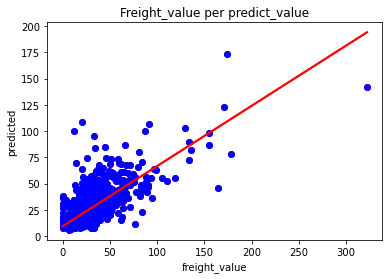

In [38]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');
plt.scatter(y_test,y_pred, color='blue')
plt.title('Freight_value per predict_value')
plt.xlabel('freight_value');
plt.ylabel('predicted');

In [39]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})

In [40]:
pred_df.head()

,Actual Value,Predicted Value,Difference
3779,22.28,20.520540,1.759460
4549,13.34,34.518735,-21.178735
8858,13.85,15.177166,-1.327166
5396,7.89,13.944660,-6.054660
2341,22.06,27.777975,-5.717975


In [41]:
for col,coef in zip(X.columns,linear.coef_):
    print("{}: {}".format(col,coef))

product_weight_g: 6.687556302968364
product_length_cm: 0.5350812371196256
product_height_cm: -1.8375811772232304
product_width_cm: -0.7551045128075831
distance: 7.637031793071028
volume_cm3: 5.994578428210184
price: 3.7343908159715036
cust_lat: 0.07205503506441979
cust_lng: -0.17943988252045148
seller_lat: -0.010405689524839773
seller_lng: -0.293468481166661


Nous pouvons remarquer si dessus que les coefficients sont tous éloignés positivement que négativement nous allons donc utilisé des modèles de regularisation pour réduire ces coefficients

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 - Ridge </h3>
</div>

C’est une régression linéaire avec une contrainte quadratique sur les coefficients. C’est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique.
quelles sont les variables très corrélées dans cet échantillon? 
- product_weight_g et volume_cm3
- product_length_cm et product_width_cm ainsi que volume_cm3
- product_height_cm avec product_weight_g et que volume_cm3
- distance avec cust_lat
- price avec volume_cm3

Beaucoup de variables étant corrélées avec volume_cm3, ce type de régression peut-être intéressante

In [42]:
clf = Ridge(alpha=1.0)
clf.fit(X_train,y_train,)

# model accuracy
print("Test R2: {}".format(clf.score(X_test,y_test)))
print("Train R2: {}".format(clf.score(X_train, y_train)))

Test R2: 0.555130872647094
Train R2: 0.602938127362211


In [43]:
# calcul des coefficient
for col,coef in zip(X.columns,clf.coef_):
    print("{}: {}".format(col,coef))

product_weight_g: 6.686738596671016
product_length_cm: 0.5360886475677358
product_height_cm: -1.8351249120518682
product_width_cm: -0.7538023358928786
distance: 7.634902088473635
volume_cm3: 5.991263125348514
price: 3.7344358127634014
cust_lat: 0.07362382218188734
cust_lng: -0.1795486868626124
seller_lat: -0.010014867663373575
seller_lng: -0.2936830615788558


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.3 - Lasso </h3>
</div>

In [44]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train,y_train)

print("Train R2: {}".format(lasso.score(X_train,y_train)))
print("Test R2: {}\n".format(lasso.score(X_test,y_test)))
for col,coef in zip(X.columns,lasso.coef_):
    print("{}: {}".format(col,coef))

Train R2: 0.6023733237128241
Test R2: 0.554878384196025

product_weight_g: 6.646143858057157
product_length_cm: 0.4910393337496306
product_height_cm: -1.3566641799954045
product_width_cm: -0.32402989567387663
distance: 7.54765482844946
volume_cm3: 5.359031106893727
price: 3.6874192362623632
cust_lat: 0.0
cust_lng: -0.028009021518116607
seller_lat: -0.0
seller_lng: -0.19100035425865408


Nous remarquons que ce modèle à peu d'impact sur la précision du modèle de regression linéaire par contre les coefficients ont bien été réduits

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.4 - ElasticNet </h3>
</div>

In [45]:
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic.fit(X_train,y_train)

print("Train R2: {}".format(elastic.score(X_train,y_train)))
print("Test R2: {}\n".format(elastic.score(X_test,y_test)))

for col,coef in zip(X.columns,elastic.coef_):
    print("{}: {}".format(col,coef))

Train R2: 0.5540526306377722
Test R2: 0.5131623364193149

product_weight_g: 4.165454151711549
product_length_cm: 1.298826006084332
product_height_cm: 0.49929851555595267
product_width_cm: 0.5380177983164314
distance: 4.169399024672417
volume_cm3: 3.2547757386933562
price: 2.8692703828246464
cust_lat: 1.3181837641103402
cust_lng: 0.0
seller_lat: 0.0
seller_lng: -0.0


La précision à legèrement diminuée pour ce model mais les coefficients sont encore plus réduit que ceux du modèle lasso

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.5 - DummyRegressor </h3>
</div>

In [46]:
dumm = DummyRegressor(strategy="mean")
dumm.fit(X_train,y_train)

print("Train R2: {}".format(dumm.score(X_train,y_train)))
print("Test R2: {}".format(dumm.score(X_test,y_test)))

Train R2: 0.0
Test R2: -0.0003624537710880116


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.6 - Conclusion </h3>
</div>

A la lumière des différents résultats obtenus 
Ridge
Test R2: 0.5972875839170333
Train R2: 0.5929593416672396

Lasso
Train R2: 0.5923858517728153
Test R2: 0.5962499865903361

Les scores de R2 de lasso et Ridge sont assez proches. 
Nous allons donc trancher avec les coefficients 


Lasso 
product_weight_g: 6.042205303771895
product_length_cm: 0.3026443997207004
product_height_cm: -1.4178354058881613
product_width_cm: -0.3688424306473514
distance: 7.594078177135897
volume_cm3: 6.063754254507203
price: 3.3669537460036305
cust_lat: 0.0
cust_lng: -0.07961754821778437
seller_lat: 0.0
seller_lng: -0.06948311938423964
component_1: 0.0

Ridge 
product_weight_g: 4.647901040970529
product_length_cm: -0.8239303092542609
product_height_cm: -3.0165411351846547
product_width_cm: -2.0320449498060924
distance: 7.806527664989952
volume_cm3: 5.153251366034305
price: 2.7316667789406317
cust_lat: 0.016601607660626537
cust_lng: -0.115408062320687
seller_lat: 0.1695737926214639
seller_lng: -0.06361832410148091
component_1: 3.0186872311514468

La répartition des coefficient est assez similaire égalemment, toutefois, les scores de la régression Lasso sont plus nombreux à tendre vers 0. Nous choisirons donc Lasso comme modèle de départ


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.7 - GridsearchCV </h3>
</div>

<div style="border: 1px solid red;" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">3.7.1 - Ridge </h3>
</div>

In [47]:
grid_ridge = GridSearchCV(Ridge(), param_grid={'alpha':[0.2,0.4,0.6,0.8,1]})

In [48]:
# reshape data for gridsearch
y_test_array = np.array(y_test)
y_test_array = y_test_array.reshape(-1,1)
y_pred_array = np.array(y_pred)
y_pred_array = y_pred_array.reshape(-1,1)

In [49]:
grid_ridge.fit(y_test_array,y_pred_array)
grid_ridge.cv_results_

{'mean_fit_time': array([0.00160513, 0.        , 0.00159931, 0.        , 0.        ]),
 'std_fit_time': array([0.00321026, 0.        , 0.00319862, 0.        , 0.        ]),
 'mean_score_time': array([0., 0., 0., 0., 0.]),
 'std_score_time': array([0., 0., 0., 0., 0.]),
 'param_alpha': masked_array(data=[0.2, 0.4, 0.6, 0.8, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.2},
  {'alpha': 0.4},
  {'alpha': 0.6},
  {'alpha': 0.8},
  {'alpha': 1}],
 'split0_test_score': array([0.50614506, 0.50614514, 0.50614522, 0.5061453 , 0.50614538]),
 'split1_test_score': array([0.43309116, 0.43309119, 0.43309122, 0.43309125, 0.43309128]),
 'split2_test_score': array([0.66951548, 0.66951546, 0.66951545, 0.66951544, 0.66951542]),
 'split3_test_score': array([0.65169349, 0.6516934 , 0.65169331, 0.65169323, 0.65169314]),
 'split4_test_score': array([0.43834515, 0.43834517, 0.4383452 , 0.43834523, 0.43834526]),
 'mean_te

<div style="border: 1px solid red;" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">3.7.2 - Lasso </h3>
</div>

In [50]:
grid_lasso = GridSearchCV(Lasso(), param_grid={'alpha':[0.2,0.4,0.6,0.8,1]})

In [51]:
# reshape data for gridsearch
y_test_array = np.array(y_test)
y_test_array = y_test_array.reshape(-1,1)
y_pred_array = np.array(y_pred)
y_pred_array = y_pred_array.reshape(-1,1)

In [52]:
grid_lasso.fit(y_test_array,y_pred_array)
grid_lasso.cv_results_

{'mean_fit_time': array([0.00159903, 0.00160551, 0.        , 0.00159717, 0.00159545]),
 'std_fit_time': array([0.00319805, 0.00321102, 0.        , 0.00319433, 0.0031909 ]),
 'mean_score_time': array([0., 0., 0., 0., 0.]),
 'std_score_time': array([0., 0., 0., 0., 0.]),
 'param_alpha': masked_array(data=[0.2, 0.4, 0.6, 0.8, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.2},
  {'alpha': 0.4},
  {'alpha': 0.6},
  {'alpha': 0.8},
  {'alpha': 1}],
 'split0_test_score': array([0.50635701, 0.50656758, 0.50677668, 0.50698432, 0.5071905 ]),
 'split1_test_score': array([0.43317473, 0.43325747, 0.43333933, 0.43342031, 0.43350042]),
 'split2_test_score': array([0.66947808, 0.66943943, 0.66939955, 0.66935843, 0.66931608]),
 'split3_test_score': array([0.65143878, 0.65118313, 0.6509266 , 0.65066921, 0.65041096]),
 'split4_test_score': array([0.43841825, 0.43849055, 0.43856204, 0.43863271, 0.43870257]),
 'mean_te

<div style="border: 1px solid red;" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">3.7.3 - ElasticNet </h3>
</div>

In [53]:
grid_elastic = GridSearchCV(ElasticNet(), param_grid={'alpha':[0.2,0.4,0.6,0.8,1]})

In [54]:
grid_elastic.fit(y_test_array,y_pred_array)
grid_elastic.cv_results_

{'mean_fit_time': array([0.        , 0.        , 0.00159674, 0.        , 0.00159888]),
 'std_fit_time': array([0.        , 0.        , 0.00319347, 0.        , 0.00319777]),
 'mean_score_time': array([0.00159869, 0.00160112, 0.        , 0.        , 0.        ]),
 'std_score_time': array([0.00319738, 0.00320225, 0.        , 0.        , 0.        ]),
 'param_alpha': masked_array(data=[0.2, 0.4, 0.6, 0.8, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.2},
  {'alpha': 0.4},
  {'alpha': 0.6},
  {'alpha': 0.8},
  {'alpha': 1}],
 'split0_test_score': array([0.50631433, 0.50648264, 0.50664993, 0.50681618, 0.50698141]),
 'split1_test_score': array([0.43315731, 0.4332229 , 0.43328792, 0.43335236, 0.43341622]),
 'split2_test_score': array([0.66948624, 0.66945625, 0.66942552, 0.66939405, 0.66936183]),
 'split3_test_score': array([0.65149761, 0.65130124, 0.65110447, 0.6509073 , 0.65070972]),
 'split4_test_score'

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.8 - Conclusion</h3>
</div>

Les résultats entre les 4 types de régression sont très similaires, il en va de même lorsque l'on modifie la dureté des paramètres. Une régression linéaire n'est donc pas adaptée pour la prévsion des frais de ports.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 4 - Analyse des variables </h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Variables quantitatives </h3>
</div>

In [55]:
corrélation_q = df.corr()
corrélation_q

,cust_lat,cust_lng,seller_lat,seller_lng,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value,distance,volume_cm3
cust_lat,1.000000,0.468820,0.111440,0.126505,-0.007423,-0.021350,-0.009783,-0.023737,0.074868,0.290943,0.709164,-0.010312
cust_lng,0.468820,1.000000,0.083224,0.116526,-0.012163,-0.028457,-0.031598,-0.009930,0.025203,0.097969,0.272506,-0.023658
seller_lat,0.111440,0.083224,1.000000,0.458301,-0.037405,-0.034075,-0.043177,-0.032371,0.025092,0.059733,0.209117,-0.042128
seller_lng,0.126505,0.116526,0.458301,1.000000,-0.014561,-0.068933,-0.012538,-0.069101,0.063353,-0.001439,0.029256,-0.036282
product_weight_g,-0.007423,-0.012163,-0.037405,-0.014561,1.000000,0.543568,0.596332,0.530708,0.341085,0.596988,-0.020160,0.831334
product_length_cm,-0.021350,-0.028457,-0.034075,-0.068933,0.543568,1.000000,0.245531,0.605952,0.188714,0.384606,-0.013579,0.608757
product_height_cm,-0.009783,-0.031598,-0.043177,-0.012538,0.596332,0.245531,1.000000,0.291337,0.214936,0.371523,-0.007481,0.711797
product_width_cm,-0.023737,-0.009930,-0.032371,-0.069101,0.530708,0.605952,0.291337,1.000000,0.176199,0.357811,-0.028299,0.646891
price,0.074868,0.025203,0.025092,0.063353,0.341085,0.188714,0.214936,0.176199,1.000000,0.419524,0.093544,0.321669
freight_value,0.290943,0.097969,0.059733,-0.001439,0.596988,0.384606,0.371523,0.357811,0.419524,1.000000,0.408608,0.582752


<AxesSubplot:>

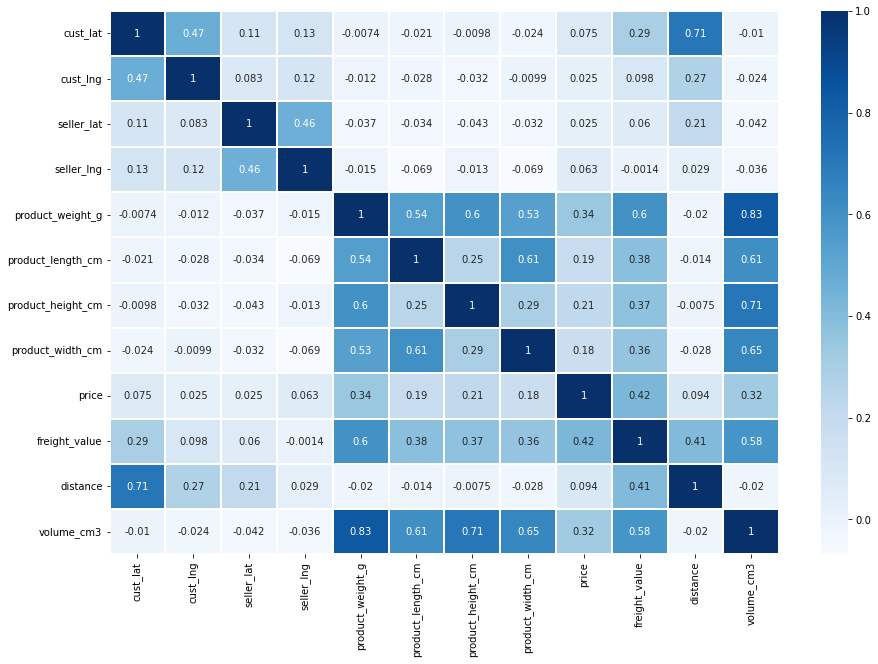

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrélation_q, cmap="Blues", annot=True, linewidths=.1)

ici les variables ayant une forte corrélation entre elles sont : 

le volume avec :
- le poids
- la longueur 
- la hauteur 
- la largeur 

la distance avec : 
- cust_lag

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.2 - Variables catégorielles </h3>
</div>

In [57]:
weight_per_category = data[["product_category_name_english","product_weight_g"]].groupby(
    by="product_category_name_english").mean().reset_index().sort_values(by="product_weight_g",ascending=False)

In [58]:
weight_per_category

,product_category_name_english,product_weight_g
53,office_furniture,12143.778846
48,kitchen_dining_laundry_garden_furniture,12022.694444
42,home_appliances_2,10808.517241
14,computers,10268.750000
38,furniture_living_room,9637.881356
...,...,...
62,tablets_printing_image,300.000000
63,telephony,299.513636
9,books_imported,262.500000
31,fashion_underwear_beach,157.142857


In [59]:
order_per_payment_type = data[["payment_type","order_id"]].groupby(
    by="payment_type").count().reset_index().sort_values(by="order_id",ascending=False)

In [60]:
order_per_payment_type

,payment_type,order_id
1,credit_card,8677
0,boleto,2085
3,voucher,505
2,debit_card,311


In [62]:
t = pd.crosstab(data.payment_type, data.product_category_name_english)
res = chi2_contingency(t)
print("p_valeur_wp : ", res[1])

p_valeur_wp :  1.854421447452731e-17


la p_value étant supérieur à 0.05 cela signifie qu'il n'y a aucune corrélation entre le type de payment et le type de catégorie 

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.3 - Variables quantitatives et catégorielles </h3>
</div>

In [63]:
table = pd.crosstab(data.product_weight_g, data.product_category_name_english)
table2 = pd.crosstab(data.freight_value, data.product_category_name_english)

In [64]:
result = chi2_contingency(table)
result2 = chi2_contingency(table2)

In [65]:
print("p_valeur_wp : ", result[1])
print("p_valeur_fp : ", result2[1])

p_valeur_wp :  0.0
p_valeur_fp :  0.0


Nous pouvons conclure que que le poids et les frais de ports ont une forte corrélation avec le type de catégorie car les p_valeur sont inférieurs à 0.005